In [1]:
import math
import numpy
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt

In [2]:
class ModelParameters:
    """
    Encapsulates model parameters
    """

    def __init__(self,
                 all_s0, all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0,
                 cir_a=0.0, cir_mu=0.0, all_r0=0.0, cir_rho=0.0,
                 ou_a=0.0, ou_mu=0.0,
                 heston_a=0.0, heston_mu=0.0, heston_vol0=0.0):
        # This is the starting asset value
        self.all_s0 = all_s0
        # This is the amount of time to simulate for
        self.all_time = all_time
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        # This is the volatility of the stochastic processes
        self.all_sigma = all_sigma
        # This is the annual drift factor for geometric brownian motion
        self.gbm_mu = gbm_mu
        # This is the probability of a jump happening at each point in time
        self.lamda = jumps_lamda
        # This is the volatility of the jump size
        self.jumps_sigma = jumps_sigma
        # This is the average jump size
        self.jumps_mu = jumps_mu
        # This is the rate of mean reversion for Cox Ingersoll Ross
        self.cir_a = cir_a
        # This is the long run average interest rate for Cox Ingersoll Ross
        self.cir_mu = cir_mu
        # This is the starting interest rate value
        self.all_r0 = all_r0
        # This is the correlation between the wiener processes of the Heston model
        self.cir_rho = cir_rho
        # This is the rate of mean reversion for Ornstein Uhlenbeck
        self.ou_a = ou_a
        # This is the long run average interest rate for Ornstein Uhlenbeck
        self.ou_mu = ou_mu
        # This is the rate of mean reversion for volatility in the Heston model
        self.heston_a = heston_a
        # This is the long run average volatility for the Heston model
        self.heston_mu = heston_mu
        # This is the starting volatility value for the Heston model
        self.heston_vol0 = heston_vol0


In [3]:
mp = ModelParameters(all_s0=1000,
                     all_r0=0.5,
                     all_time=800,
                     all_delta=0.00396825396,
                     all_sigma=0.125,
                     gbm_mu=0.058,
                     jumps_lamda=0.00125,
                     jumps_sigma=0.001,
                     jumps_mu=-0.2,
                     cir_a=3.0,
                     cir_mu=0.5,
                     cir_rho=0.5,
                     ou_a=3.0,
                     ou_mu=0.5,
                     heston_a=0.25,
                     heston_mu=0.35,
                     heston_vol0=0.06125)

paths = 15


In [4]:
def plot_stochastic_processes(processes, title):
    """
    This method plots a list of stochastic processes with a specified title
    :return: plots the graph of the two
    """
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle(title, fontsize=16)
    ax.set_xlabel('Time, t')
    ax.set_ylabel('Simulated Asset Price')
    x_axis = numpy.arange(0, len(processes[0]), 1)
    for i in range(len(processes)):
        plt.plot(x_axis, processes[i])
    plt.show()


In [5]:
def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    :param log_returns: the log returns to exponentiated
    :return: the exponentiated returns
    """
    return numpy.exp(log_returns)

In [6]:
def convert_to_prices(param, log_returns):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    :param param: the model parameters object
    :param log_returns: the log returns to exponentiated
    :return:
    """
    returns = convert_to_returns(log_returns)
    # A sequence of prices starting with param.all_s0
    price_sequence = [param.all_s0]
    for i in range(1, len(returns)):
        # Add the price at t-1 * return at t
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return numpy.array(price_sequence)

In [7]:
def brownian_motion_log_returns(param):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    :param param: the model parameters object
    :return: brownian motion log returns
    """
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    return nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)

In [8]:
def brownian_motion_levels(param):
    """
    Returns a price sequence whose returns evolve according to a brownian motion
    :param param: model parameters object
    :return: returns a price sequence which follows a brownian motion
    """
    return convert_to_prices(param, brownian_motion_log_returns(param))


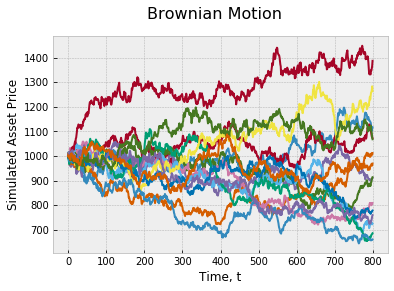

In [9]:
brownian_motion_examples = []
for i in range(paths):
    brownian_motion_examples.append(brownian_motion_levels(mp))
plot_stochastic_processes(brownian_motion_examples, "Brownian Motion")

In [10]:
def geometric_brownian_motion_log_returns(param):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    :param param: model parameters object
    :return: returns the log returns of a geometric brownian motion process
    """
    assert isinstance(param, ModelParameters)
    wiener_process = numpy.array(brownian_motion_log_returns(param))
    sigma_pow_mu_delta = (param.gbm_mu - 0.5 * math.pow(param.all_sigma, 2.0)) * param.all_delta
    return wiener_process + sigma_pow_mu_delta

def geometric_brownian_motion_levels(param):
    """
    Returns a sequence of price levels for an asset which evolves according to a geometric brownian motion
    :param param: model parameters object
    :return: the price levels for the asset
    """
    return convert_to_prices(param, geometric_brownian_motion_log_returns(param))

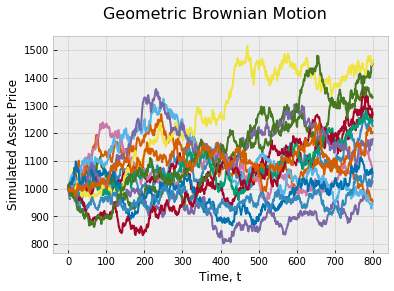

In [11]:
geometric_brownian_motion_examples = []
for i in range(paths):
    geometric_brownian_motion_examples.append(geometric_brownian_motion_levels(mp))
plot_stochastic_processes(geometric_brownian_motion_examples, "Geometric Brownian Motion")

In [12]:
def jump_diffusion_process(param):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    :param param: the model parameters object
    :return: jump sizes for each point in time (mostly zeroes if jumps are infrequent)
    """
    assert isinstance(param, ModelParameters)
    s_n = time = 0
    small_lamda = -(1.0 / param.lamda)
    jump_sizes = []
    for k in range(0, param.all_time):
        jump_sizes.append(0.0)
    while s_n < param.all_time:
        s_n += small_lamda * math.log(random.uniform(0, 1))
        for j in range(0, param.all_time):
            if time * param.all_delta <= s_n * param.all_delta <= (j + 1) * param.all_delta:
                # print("was true")
                jump_sizes[j] += random.normalvariate(param.jumps_mu, param.jumps_sigma)
                break
        time += 1
    return jump_sizes

def geometric_brownian_motion_jump_diffusion_log_returns(param):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    :param param: model parameters object
    :return: returns a GBM process with jumps in it
    """
    assert isinstance(param, ModelParameters)
    jump_diffusion = jump_diffusion_process(param)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(param)
    return numpy.add(jump_diffusion, geometric_brownian_motion)


def geometric_brownian_motion_jump_diffusion_levels(param):
    """
    This method converts a sequence of gbm jmp returns into a price sequence which evolves according to a geometric
    brownian motion but can contain jumps at any point in time.
    :param param: model parameters object
    :return: the price levels
    """
    return convert_to_prices(param, geometric_brownian_motion_jump_diffusion_log_returns(param))

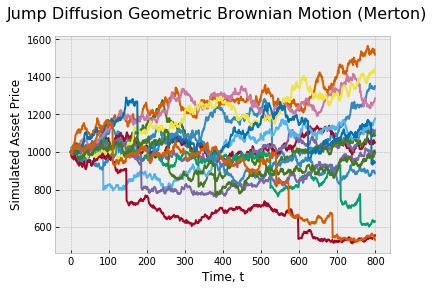

In [13]:
jump_diffusion_examples = []
for i in range(paths):
    jump_diffusion_examples.append(geometric_brownian_motion_jump_diffusion_levels(mp))
plot_stochastic_processes(jump_diffusion_examples, "Jump Diffusion Geometric Brownian Motion (Merton)")

In [14]:
def heston_construct_correlated_path(param, brownian_motion_one):
    """
    This method is a simplified version of the Cholesky decomposition method for just two assets. It does not make use
    of matrix algebra and is therefore quite easy to implement.
    :param param: model parameters object
    :return: a correlated brownian motion path
    """
    # We do not multiply by sigma here, we do that in the Heston model
    sqrt_delta = math.sqrt(param.all_delta)
    # Construct a path correlated to the first path
    brownian_motion_two = []
    for i in range(param.all_time - 1):
        term_one = param.cir_rho * brownian_motion_one[i]
        term_two = math.sqrt(1 - math.pow(param.cir_rho, 2.0)) * random.normalvariate(0, sqrt_delta)
        brownian_motion_two.append(term_one + term_two)
    return numpy.array(brownian_motion_one), numpy.array(brownian_motion_two)

def get_correlated_geometric_brownian_motions(param, correlation_matrix, n):
    """
    This method can construct a basket of correlated asset paths using the Cholesky decomposition method
    :param param: model parameters object
    :param correlation_matrix: nxn correlation matrix
    :param n: the number of assets i.e. the number of paths to return
    :return: n correlated log return geometric brownian motion processes
    """
    assert isinstance(param, ModelParameters)
    decomposition = scipy.linalg.cholesky(correlation_matrix, lower=False)
    uncorrelated_paths = []
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    # Construct uncorrelated paths to convert into correlated paths
    for i in range(param.all_time):
        uncorrelated_random_numbers = []
        for j in range(n):
            uncorrelated_random_numbers.append(random.normalvariate(0, sqrt_delta_sigma))
        uncorrelated_paths.append(numpy.array(uncorrelated_random_numbers))
    uncorrelated_matrix = numpy.matrix(uncorrelated_paths)
    correlated_matrix = uncorrelated_matrix * decomposition
    assert isinstance(correlated_matrix, numpy.matrix)
    # The rest of this method just extracts paths from the matrix
    extracted_paths = []
    for i in range(1, n + 1):
        extracted_paths.append([])
    for j in range(0, len(correlated_matrix)*n - n, n):
        for i in range(n):
            extracted_paths[i].append(correlated_matrix.item(j + i))
    return extracted_paths

In [15]:
def cox_ingersoll_ross_heston(param):
    """
    This method returns the rate levels of a mean-reverting cox ingersoll ross process. It is used to model interest
    rates as well as stochastic volatility in the Heston model. Because the returns between the underlying and the
    stochastic volatility should be correlated we pass a correlated Brownian motion process into the method from which
    the interest rate levels are constructed. The other correlated process is used in the Heston model
    :param param: the model parameters objects
    :return: the interest rate levels for the CIR process
    """
    # We don't multiply by sigma here because we do that in heston
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    brownian_motion_volatility = nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)
    a, mu, zero = param.heston_a, param.heston_mu, param.heston_vol0
    volatilities = [zero]
    for i in range(1, param.all_time):
        drift = a * (mu - volatilities[i-1]) * param.all_delta
        randomness = math.sqrt(max(volatilities[i - 1], 0.05)) * brownian_motion_volatility[i - 1]
        volatilities.append(max(volatilities[i - 1], 0.05) + drift + randomness)
    return numpy.array(brownian_motion_volatility), numpy.array(volatilities)

In [16]:
def heston_model_levels(param):
    """
    NOTE - this method is dodgy! Need to debug!
    The Heston model is the geometric brownian motion model with stochastic volatility. This stochastic volatility is
    given by the cox ingersoll ross process. Step one on this method is to construct two correlated GBM processes. One
    is used for the underlying asset prices and the other is used for the stochastic volatility levels
    :param param: model parameters object
    :return: the prices for an underlying following a Heston process
    """
    assert isinstance(param, ModelParameters)
    # Get two correlated brownian motion sequences for the volatility parameter and the underlying asset
    # brownian_motion_market, brownian_motion_vol = get_correlated_paths_simple(param)
    brownian, cir_process = cox_ingersoll_ross_heston(param)
    brownian, brownian_motion_market = heston_construct_correlated_path(param, brownian)

    heston_market_price_levels = [param.all_s0]
    for i in range(1, param.all_time):
        drift = param.gbm_mu * heston_market_price_levels[i - 1] * param.all_delta
        vol = cir_process[i - 1] * heston_market_price_levels[i - 1] * brownian_motion_market[i - 1]
        heston_market_price_levels.append(heston_market_price_levels[i - 1] + drift + vol)
    return numpy.array(heston_market_price_levels), numpy.array(cir_process)

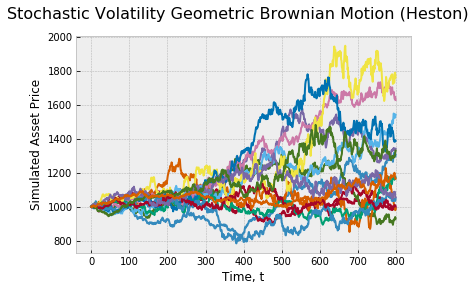

In [17]:
stochastic_volatility_examples = []
for i in range(paths):
    stochastic_volatility_examples.append(heston_model_levels(mp)[0])
plot_stochastic_processes(stochastic_volatility_examples, "Stochastic Volatility Geometric Brownian Motion (Heston)")

# Stochastic Processes
* Create a stochastic generator function that would go into the existing episode generator
* Focus on merton and heston generation

```python
class StochasticCoinGenerator(object):
    def __init__(self):
        pass
      
    def generate(self, coin_bars, length):
        # Get normal distribution of the close, high, low, volume
        # Get normal distribution of the 
        
        
```